# Application of Long Short-Term Memory (LSTM) for hydrological simulation in Kaligandaki Basin Nepal
***
The application of Long Short-Term Memory (LSTM) models for streamflow predictions has been an area of rapid development, supported by advancements in computing technology, increasing availability of spatiotemporal data, and availability of historical data that allows for training data-driven LSTM models (Khand & Senay, 2021). In this study, a LSTM model was developed to simulate daily streamflow, using a sequence of historical rainfall and discharge data. The dataset was split with a 70%–30% ratio for training and testing, respectively. The model's performance was evaluated by comparing the simulated streamflow against observed data using the Nash-Sutcliffe Efficiency (NSE) metric, achieving NSE scores of 0.8479 for the training period and 0.8530 for the testing period. In general, model simulation can be judged 
as satisfactory if NSE > 0.5 (Moriasi et al., 2007). 0In particular, the model demonstrated high accuracy in predicting baseflow values. Additionally, residual error analysis quantified discrepancies between observed and predicted values, while flow duration curves were used to assess prediction accuracy across varying flow conditions. This comprehensive evaluation underscores the LSTM model’s effectiveness for daily streamflow predictions, supporting its application in hydrological modeling.

### Long Short-Term Memory (LSTM)

**Long Short-Term Memory (LSTM)** is a type of recurrent neural network (RNN) specifically designed to handle sequences of data. Unlike traditional RNNs, which can suffer from issues like the vanishing gradient problem, LSTMs are equipped with mechanisms called "gates" that help them retain or forget information over long sequences.

LSTMs consist of three main gates:
1. **Input Gate**: Decides what new information should be added to the cell state.
2. **Forget Gate**: Determines what information should be discarded from the cell state.
3. **Output Gate**: Controls the output from the current cell state.

These gates enable LSTMs to effectively capture dependencies over long periods, making them ideal for tasks involving time-series data, such as weather forecasting, stock price prediction, and hydrological modeling. Their ability to retain memory over time steps makes them particularly useful in processing and predicting seque patterns. LSTM models have been utilized to improve the accuracy of water demand (Nearing et al, 2021). There has been studies to connect the climatic factors and water demand predicting the societal water needs (Zanfei et al, 2022).

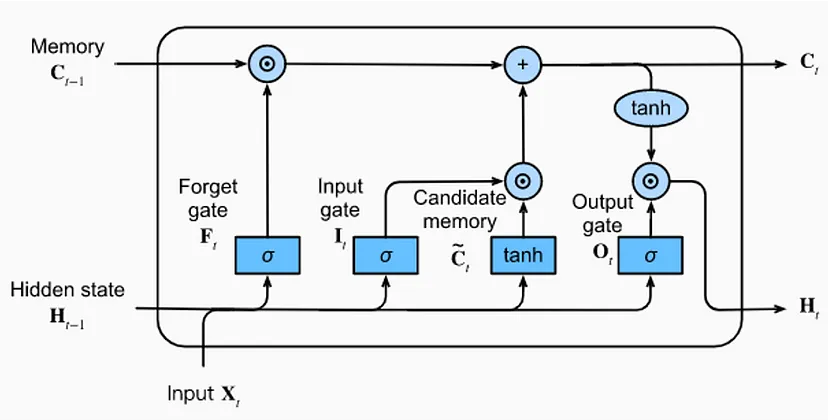atterns.


### Study Area
The **Kalignadaki Basin** is an important sub-basin of the larger Gandaki River Basin (also known as the Narayani Basin. The Gandaki Basin is one of the major river systems in Nepal which is major tributary of the Ganges River Basin. The northen region of the Kaligandaki Basin is characterized by higher altitudes and some glacial coverage with 33 % of the basin covered in snow perenially (Bajracharya et al., 2018). And the southern part having a sub-tropical climate fetches high precipitation. The outlet of the Kaligandaki Basin is at its confluence with the Trishuli River, forming the Narayani River near Devghat. It then continues its dlow towards the Ganges as part of the Gandaki River System.
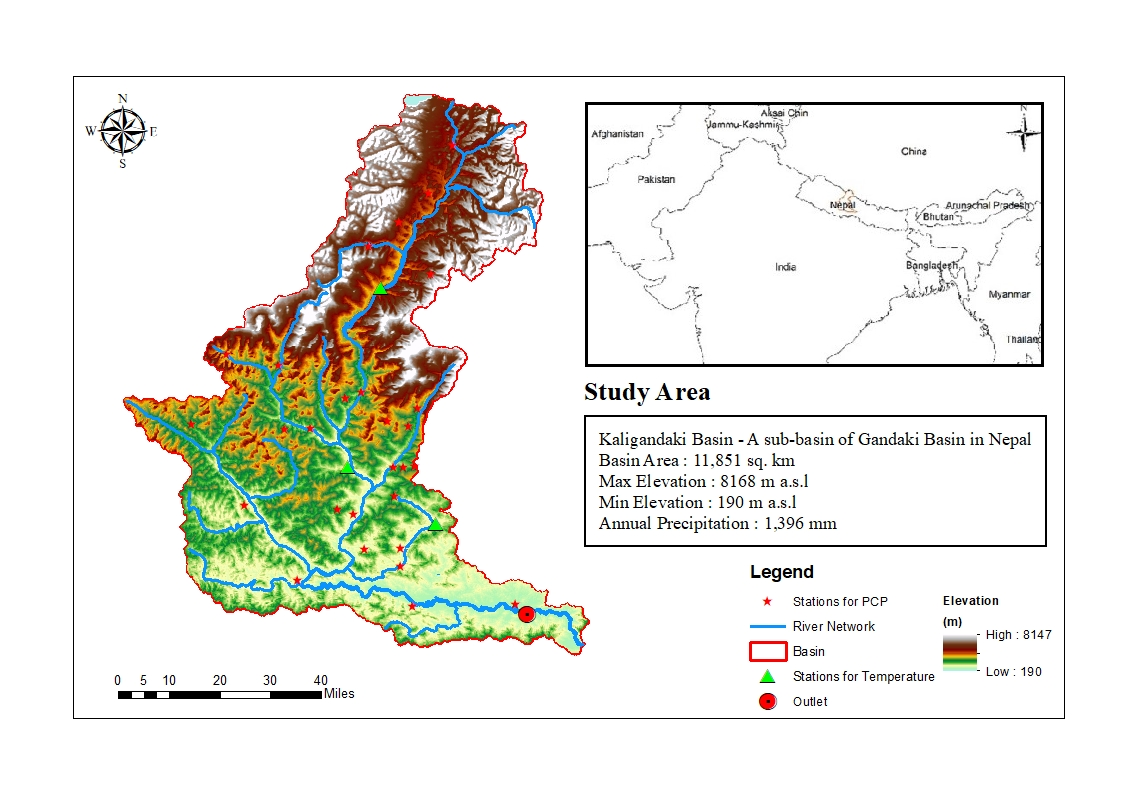

In [217]:
#importing needed libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import matplotlib.pyplot as plt


In [218]:
import tensorflow as tf
import random

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

## Data
The dataset comprises 7,306 rows and 4 columns capturing daily data from January 1, 1996 to December 31, 2015, across 20-year span. The 4 columns include **Date**, **Discharge**, **Rainfall**, and **Temperature** values. These data were collected through the Department of Hydrology and Meteorology, Nepal for the Kaligandaki Basin. The precipitation data used were recorded in 28 stations and the temperature data from three stations, Jomsom, Baglung, and Syangja was used for this study. The Theissen Polygon method was used to calculate the mean rainfall data from the 28 stations to acheive a more accurate spatial distribution of the precipitation data.

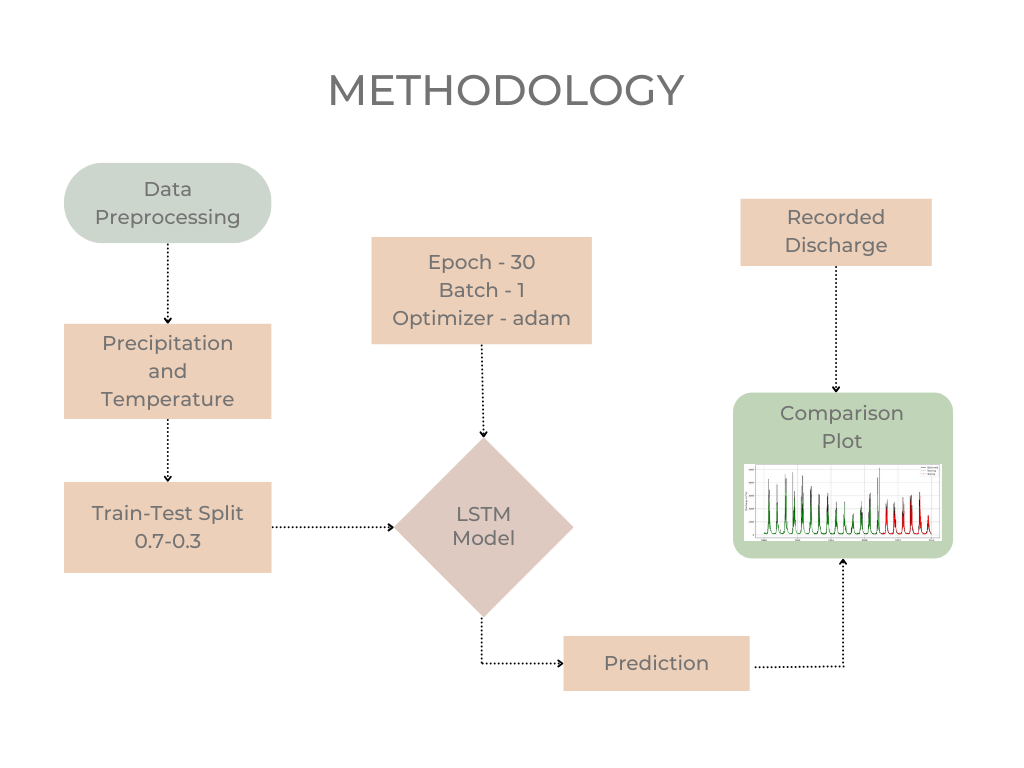

### Theissen Polygon Method

<div style="display: flex; align-items: center;">
    <div style="flex: 1;">
        The Thiessen Polygon method is a spatial partitioning technique that divides a geographic area into polygons based on proximity to a set of points, like measurement stations. This method involves creating polygons around each data point so that all locations within a polygon are closer to its associated point than to any other point in the set. The process involves drawing perpendicular bisectors between adjacent points to form boundaries, establishing zones that represent areas of equal distance from each station. This approach is particularly valuable for spatial analyses in hydrology, meteorology, and environmental science, where accurate representation of influence areas is essential.
        In this study, the Thiessen polygons were generated using the spatial analyst tool of ArcGIS and the theissen weights were used to calculate the mean precipitation in the basin. 
    </div>
    <div style="flex: 0;">
        <img src="Thiessen_Polygon_Method.png" alt="Image description" width="2500"/>
    </div>
</div>




### Data visualisation 
The dataset available in a CSV file names rain.csv is loaded into a pandas DataFrame and then we converted the data column from a string format to a *datetime* format using pd.to_datetime. This conversion will allow us to organise and access the data entries chronologically which we used for plotting and time series analysis.

In [221]:
data = pd.read_csv('rain.csv')
#The data has columns: ['date', 'discharge', 'rain', 'temperatute']
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

Below is a figure with two vertically stacked subplots for our variables Rainfall and Temperature data with their respective date stamp. 

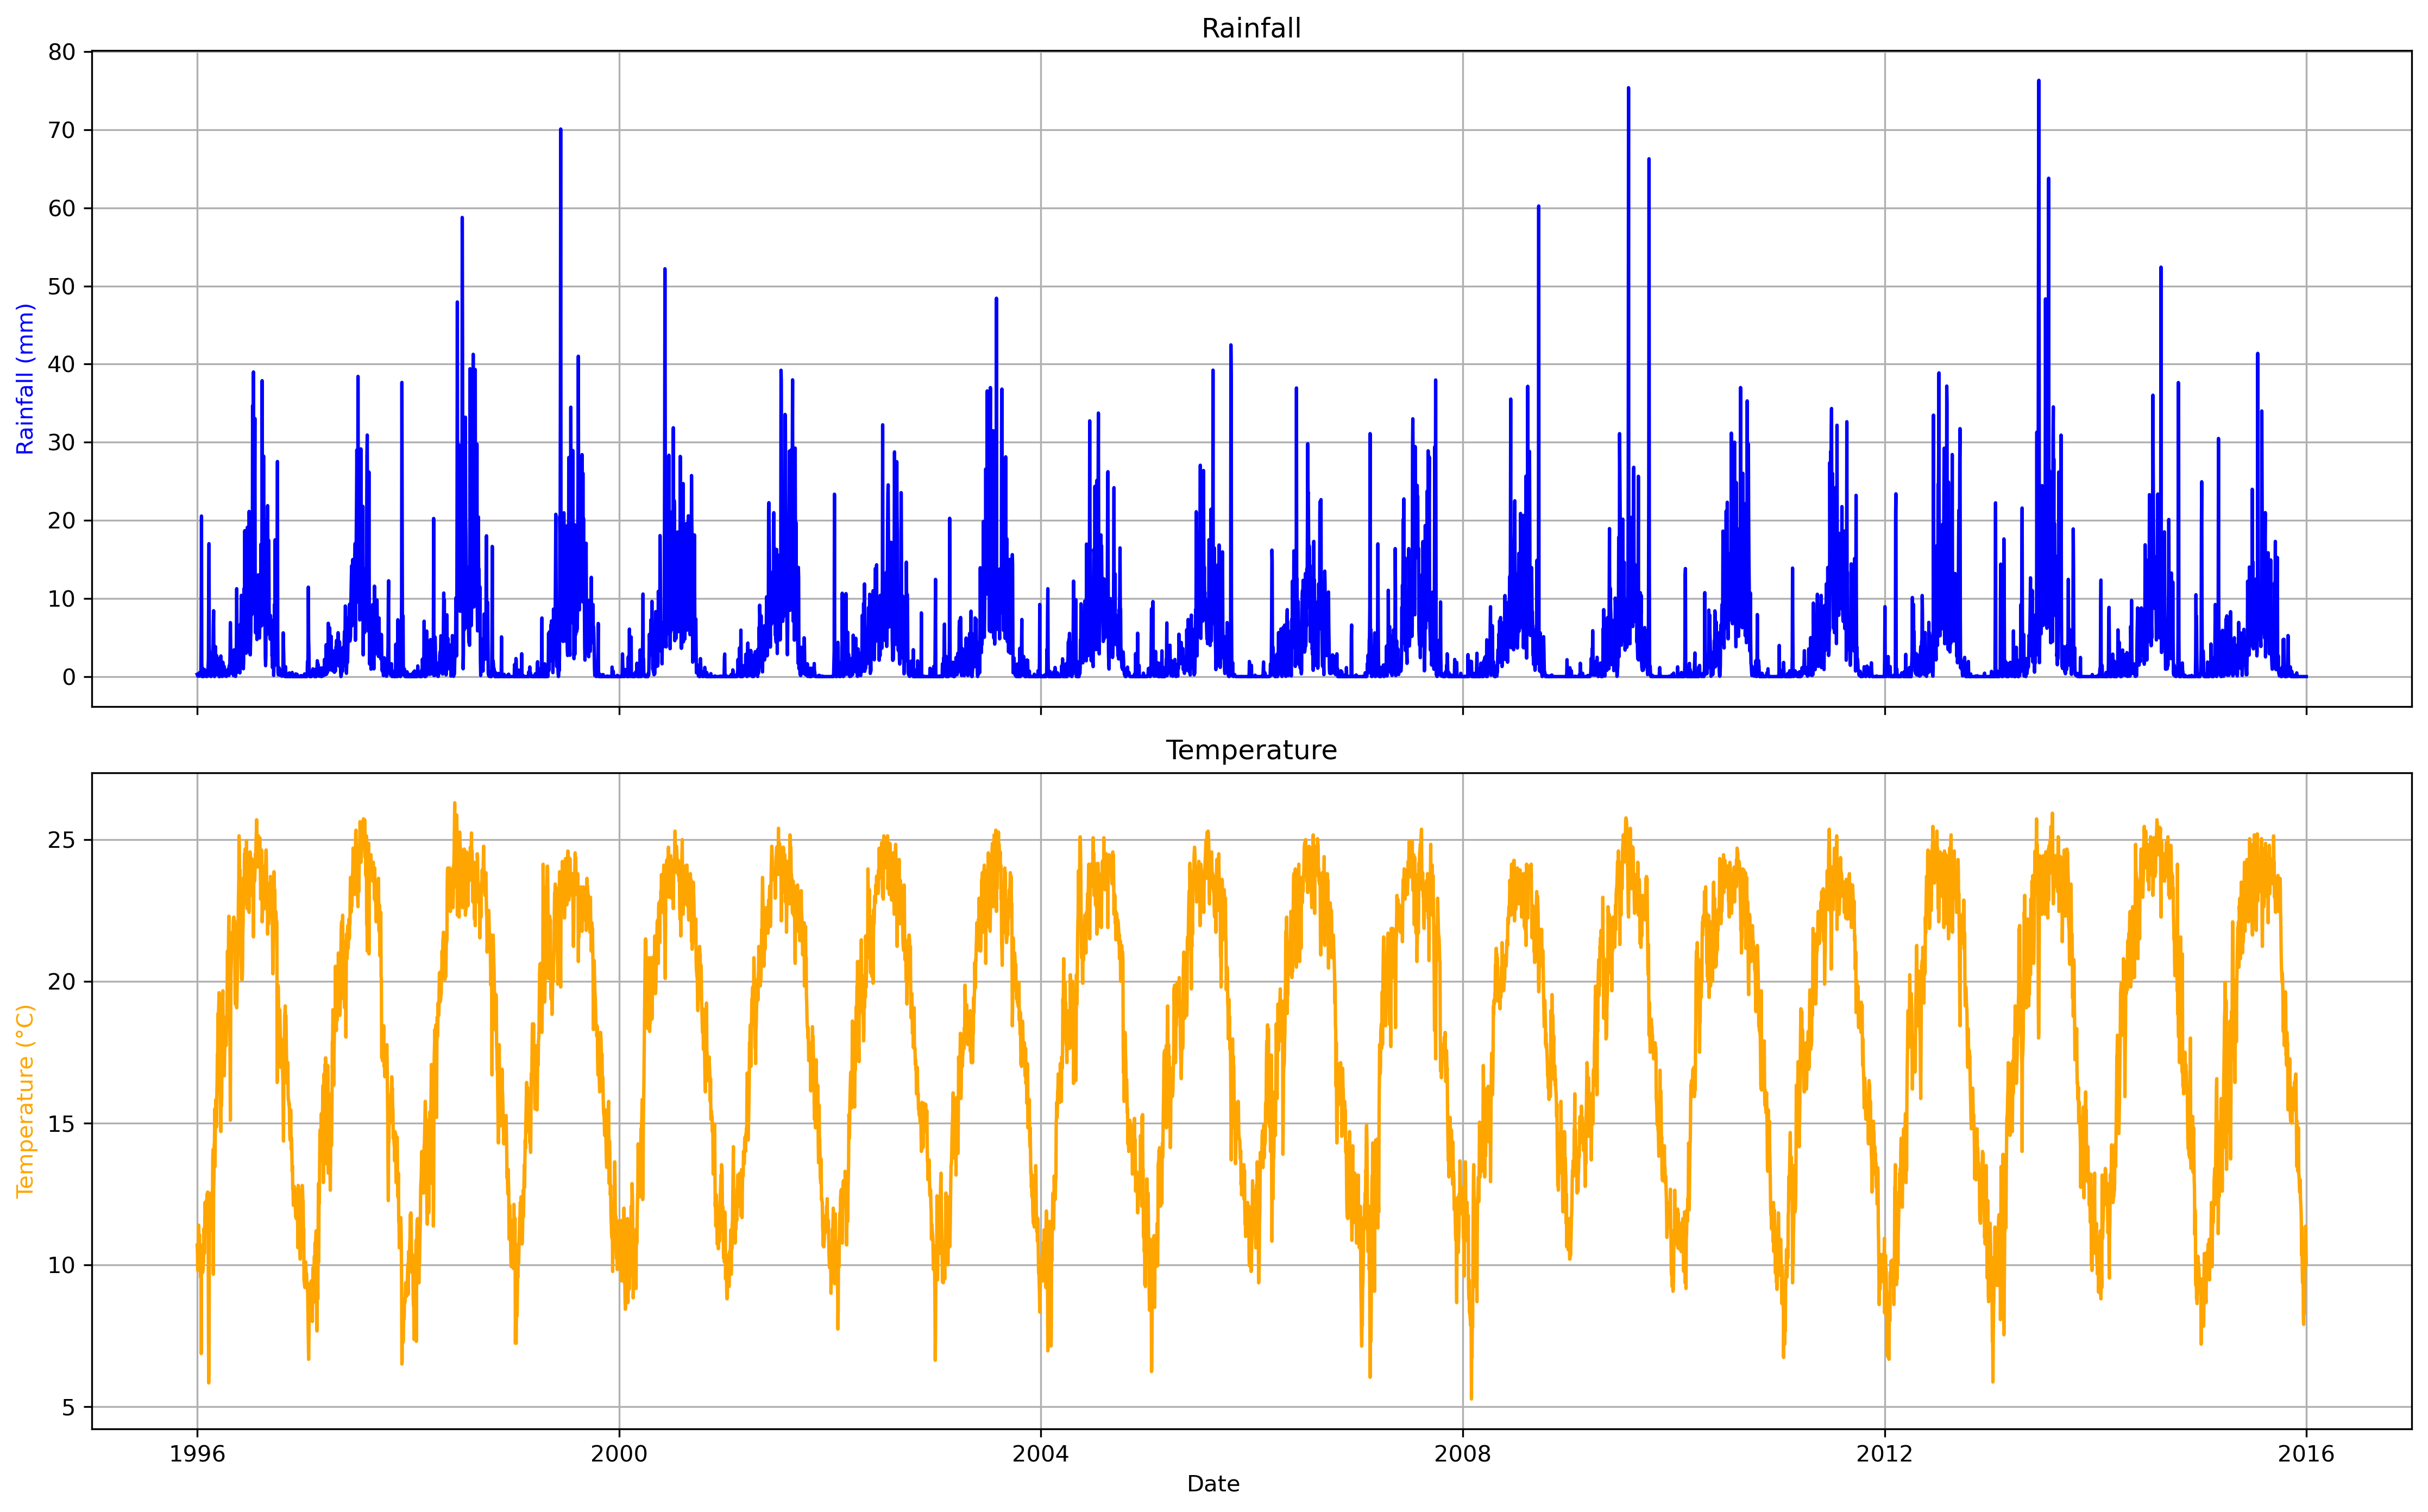

In [223]:
# Create a figure with two subplots, arranged vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), dpi=300, sharex=True)

# Rainfall vs. Date
ax1.plot(data.index, data['rain'], color='blue')
ax1.set_ylabel('Rainfall (mm)', color='blue')
ax1.set_title('Rainfall')
ax1.grid(True)

# Temperature vs. Date
ax2.plot(data.index, data['temperature'], color='orange')
ax2.set_ylabel('Temperature (°C)', color='orange')
ax2.set_title('Temperature')
ax2.grid(True)

# Add a common x-axis label
fig.text(0.5, 0.04, 'Date', ha='center')

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0.04, 1, 0.96])  # Prevent overlap and add space for x-axis label
plt.show()


The graphs above show the long-term patterns of rainfall (top) and temperature (bottom) during the study period in the Kaligandaki Basin. The rainfall plot distinctly demonstrates the seasonal pattern where high rainfall occurs in the monsoon season of Nepal during June to September. High peaks exceeding 60 mm can be seen. This is typical in Nepal where the monsoon season brings heavy rains due to the moisture-laden winds from the Bay of Bengal. The dry seasons from October to May, shows much lower rainfall, with some periods having zero rainfall too. The temperature plot shows hottest temperatures recorded in May to September and coldest during December to February. Based on the rainfall pattern, we can expect high streamflow during the monsoon season and low flows in the dry season. The pre-monsoon period (march-May) while generally warmer, still has limited rainfall, so runoff remains low, though slightly hihger than in winter due to occasional pre monsoon showers.

While dealing neural networks, normalizing the data is very useful as the neural networks train more effeciently when the input features are scaled to a consistent range. Using the MinMaxScaler from sklear.preprocessing, we scaled each feature to range of 0 and 1. This improves the training stability and speed.

In [225]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

Now to prepare the data for our LSTM model, we need to created an input dataset through which our model learns temporal patterns using the sequences of input data to predict the next step. Here, I have chosen time step to be 10. This means that 10 input data will be used to predict the 11th. So **X** will contain the time series sequence shape, to be used as input data and **y** will contain the corresponding output values for each sequence in **X**.

In [227]:
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), :]
        X.append(a)
        y.append(data[i + time_step, 0]) 
    return np.array(X), np.array(y)

In [228]:
time_step = 10
X, y = create_dataset(data_scaled, time_step)

Now, we have our input data "**X**", but we need to reshape this input data to ensure compatibility with the LSTM layer as the model expects input data in a specific 3D shape : ***[samples, time steps, features]***. Thres represent the number of training examples, sequence length and number of variables in each time step, respectively.

In [230]:
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

Furthermore, to train our model, we have split out data into training and testing set, with 70% of samples used for training and 30% for testing. As we have 20 years of data from 1996, we have set our model to be trained by data from 1996 to 2010 and to be tested on data from 2011 to 2016.  

In [232]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

### LSTM model configuration
This LSTM model is designed to predict a time-based value - daily streamflow, by recognizing patterns over sequences of past data. It begins with an intial LSTM layer with 50 units that captures temporal patterns across multiple time steps and outputs a sequence to the next LSTM layer. The second layer also 50 units reduces the the sequence from the first layer to a single sequence which is passed to a dense layer with 25 neurons. Here, the extracted features are further refined to a an output layer with one neuron that produces the model's prediction. The model is compilation is done by using *adam* optimizer and *MSE* as the loss function and fitted with 30 epochs. Fewer epochs could not accurately predict the base flow while a higher number of epoch predicted the base flow but a lag was seen in the peaks. Hence, for computation purposes and higher accuracy, 30 epochs with batch size 1 was chosen.
As mentioned above, LSTM models consists for main three gates. In this model, the three gates are :
1. The **input gate** takes in the sequence data from the past 10 days. The LSTM layer uses 50 units to process this input and relates the variables to discharge.
2. The **forget gate** discards irrelevant parts of the the previous information. The model self decides what is essential and what is not for the model to retain. This helps the model to manage the long-term dependencies that are necessary for streamflow forecast.
3. The **output gate** analyses the input sequence and this layer will produce an output which will be the prediction, or a sequence which again will be an input to the model. Hte final output gate will then provide an updated prediction.

In [234]:
# Build the LSTM model with an Input layer
model = Sequential()
model.add(Input(shape=(time_step, X.shape[2])))  # Specify the input shape here
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=30)

Epoch 1/30
5105/5105 ━━━━━━━━━━━━━━━━━━━━ 52s 8ms/step - loss: 0.0042
Epoch 2/30
5105/5105 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step - loss: 0.0027
Epoch 3/30
5105/5105 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 0.0025
Epoch 4/30
5105/5105 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - loss: 0.0024
Epoch 5/30
5105/5105 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - loss: 0.0024
Epoch 6/30
5105/5105 ━━━━━━━━━━━━━━━━━━━━ 35s 7ms/step - loss: 0.0023
Epoch 7/30
5105/5105 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - loss: 0.0023
Epoch 8/30
5105/5105 ━━━━━━━━━━━━━━━━━━━━ 38s 8ms/step - loss: 0.0022
Epoch 9/30
5105/5105 ━━━━━━━━━━━━━━━━━━━━ 35s 7ms/step - loss: 0.0022
Epoch 10/30
5105/5105 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - loss: 0.0022
Epoch 11/30
5105/5105 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 0.0021
Epoch 12/30
5105/5105 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step - loss: 0.0021
Epoch 13/30
5105/5105 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 0.0021
Epoch 14/30
5105/5105 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - loss: 0.0021
Epoch 15/30
510

In the code, predictions were made on both the training and testing data using the trained model. Since the data was initially scaled for normalization, these predictions needed to be converted back to the original scale to interpret the results meaningfully. To achieve this, the predictions and actual values were extended with additional columns of zeros, aligning with the original data's dimensionality before scaling. This adjustment allowed for a proper reverse transformation of the scaling. Finally, only the first column, containing the discharge values, was extracted, giving the original-scale values for further analysis or visualization.

In [236]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], data_scaled.shape[1] - 1))), axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], data_scaled.shape[1] - 1))), axis=1))[:, 0]

# Inverse transform actual values
y_train = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], data_scaled.shape[1] - 1))), axis=1))[:, 0]
y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], data_scaled.shape[1] - 1))), axis=1))[:, 0]


160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [237]:
# Calculate NSE
def nse(observed, simulated):
    return 1 - (np.sum((observed - simulated) ** 2) / np.sum((observed - np.mean(observed)) ** 2))

nse_train = nse(y_train, train_predict)
nse_test = nse(y_test, test_predict)

print(f'NSE for training period: {nse_train}')
print(f'NSE for testing period: {nse_test}')

NSE for training period: 0.8478789557069362
NSE for testing period: 0.8529627723049419


### Nash-Sutcliffe Efficiency (NSE)

The **Nash-Sutcliffe efficiency (NSE)** is a normalized statistic that determines the relative magnitude of the residual variance (“noise”) compared to the measured data variance (“information”) (Nash and Sutcliffe, 1970). It compares model predictions with observed data:

#### Formula
$$
\text{NSE} = 1 - \frac{\sum_{i=1}^{N} (O_i - P_i)^2}{\sum_{i=1}^{N} (O_i - \bar{O})^2}
$$

Where:  
<ul>
  <li>\( O_i \) = Observed value at time \( i \)</li>
  <li>\( P_i \) = Predicted value at time \( i \)</li>
  <li>\( \bar{O} \) = Mean of observed values</li>
  <li>\( N \) = Total number of observations</li>
</ul>

#### Interpretation:
- **NSE = 1**: Perfect fit
- **0 < NSE < 1**: Acceptable, with values closer to 1 being better
- **NSE = 0**: Model is as accurate as the mean of observed values
- **NSE < 0**: Poor performance

#### Why NSE is Good for Hydrological Models

Nash-Sutcliffe Efficiency (NSE) is widely used in hydrological modeling due to its strengths in assessing model performance:

1. **Captures Variability**: NSE evaluates how well the model reproduces the observed variability, key for hydrological dynamics.
2. **Easy Interpretation**: NSE ranges from -∞ to 1, where 1 indicates perfect predictions. Values closer to 0 or negative show poorer model performance.
3. **Emphasizes Timing and Magnitude**: NSE heavily penalizes timing and magnitude errors, essential for peak flows and seasonal patterns.
4. **Sensitive to Errors**: NSE highlights large residuals, helping identify model performance issues for extreme events like floods.
5. **Hydrology Standard**: As a widely accepted metric, NSE enables easy benchmarking and communication of model results across studies.

---

In our case the NSE for the testing and training periods are :
- **NSE for training** : 0.8479
- **NSE for testing** : 0.8530

NSE close to 1 in both training and testing indicates that the model fits the data well. Typically, a higher NSE for testing than training in not anticipated. However, here we face it. Given that the NSE for testing is slightly higher than for training, it might indicate that the model avoided overfitting. It could also be justified as the peaks at the training periods could have high variance than that of the testing period. Overall, this is a positive result sreamflow and flood predictions.
ositive repredictions.
mflow and flood predictions.


To visualize the predictions, we use matplotlib.plt. To create placeholders for plotting the training and testing predictions alongside the observed data. By shifting the the predictions we align each predicted (train and test) with the correct index on the time series plot.

In [240]:
# Shift train predictions for plotting
train_predict_plot = np.full_like(data_scaled[:, 0], np.nan)
train_predict_plot[time_step:len(train_predict) + time_step] = train_predict
# Shift test predictions for plotting
test_predict_plot = np.full_like(data_scaled[:, 0], np.nan)
start_idx = len(train_predict) + (time_step * 2)
end_idx = start_idx + len(test_predict)
if end_idx > len(test_predict_plot):
    end_idx = len(test_predict_plot)
test_predict_plot[start_idx:end_idx] = test_predict[:end_idx - start_idx]


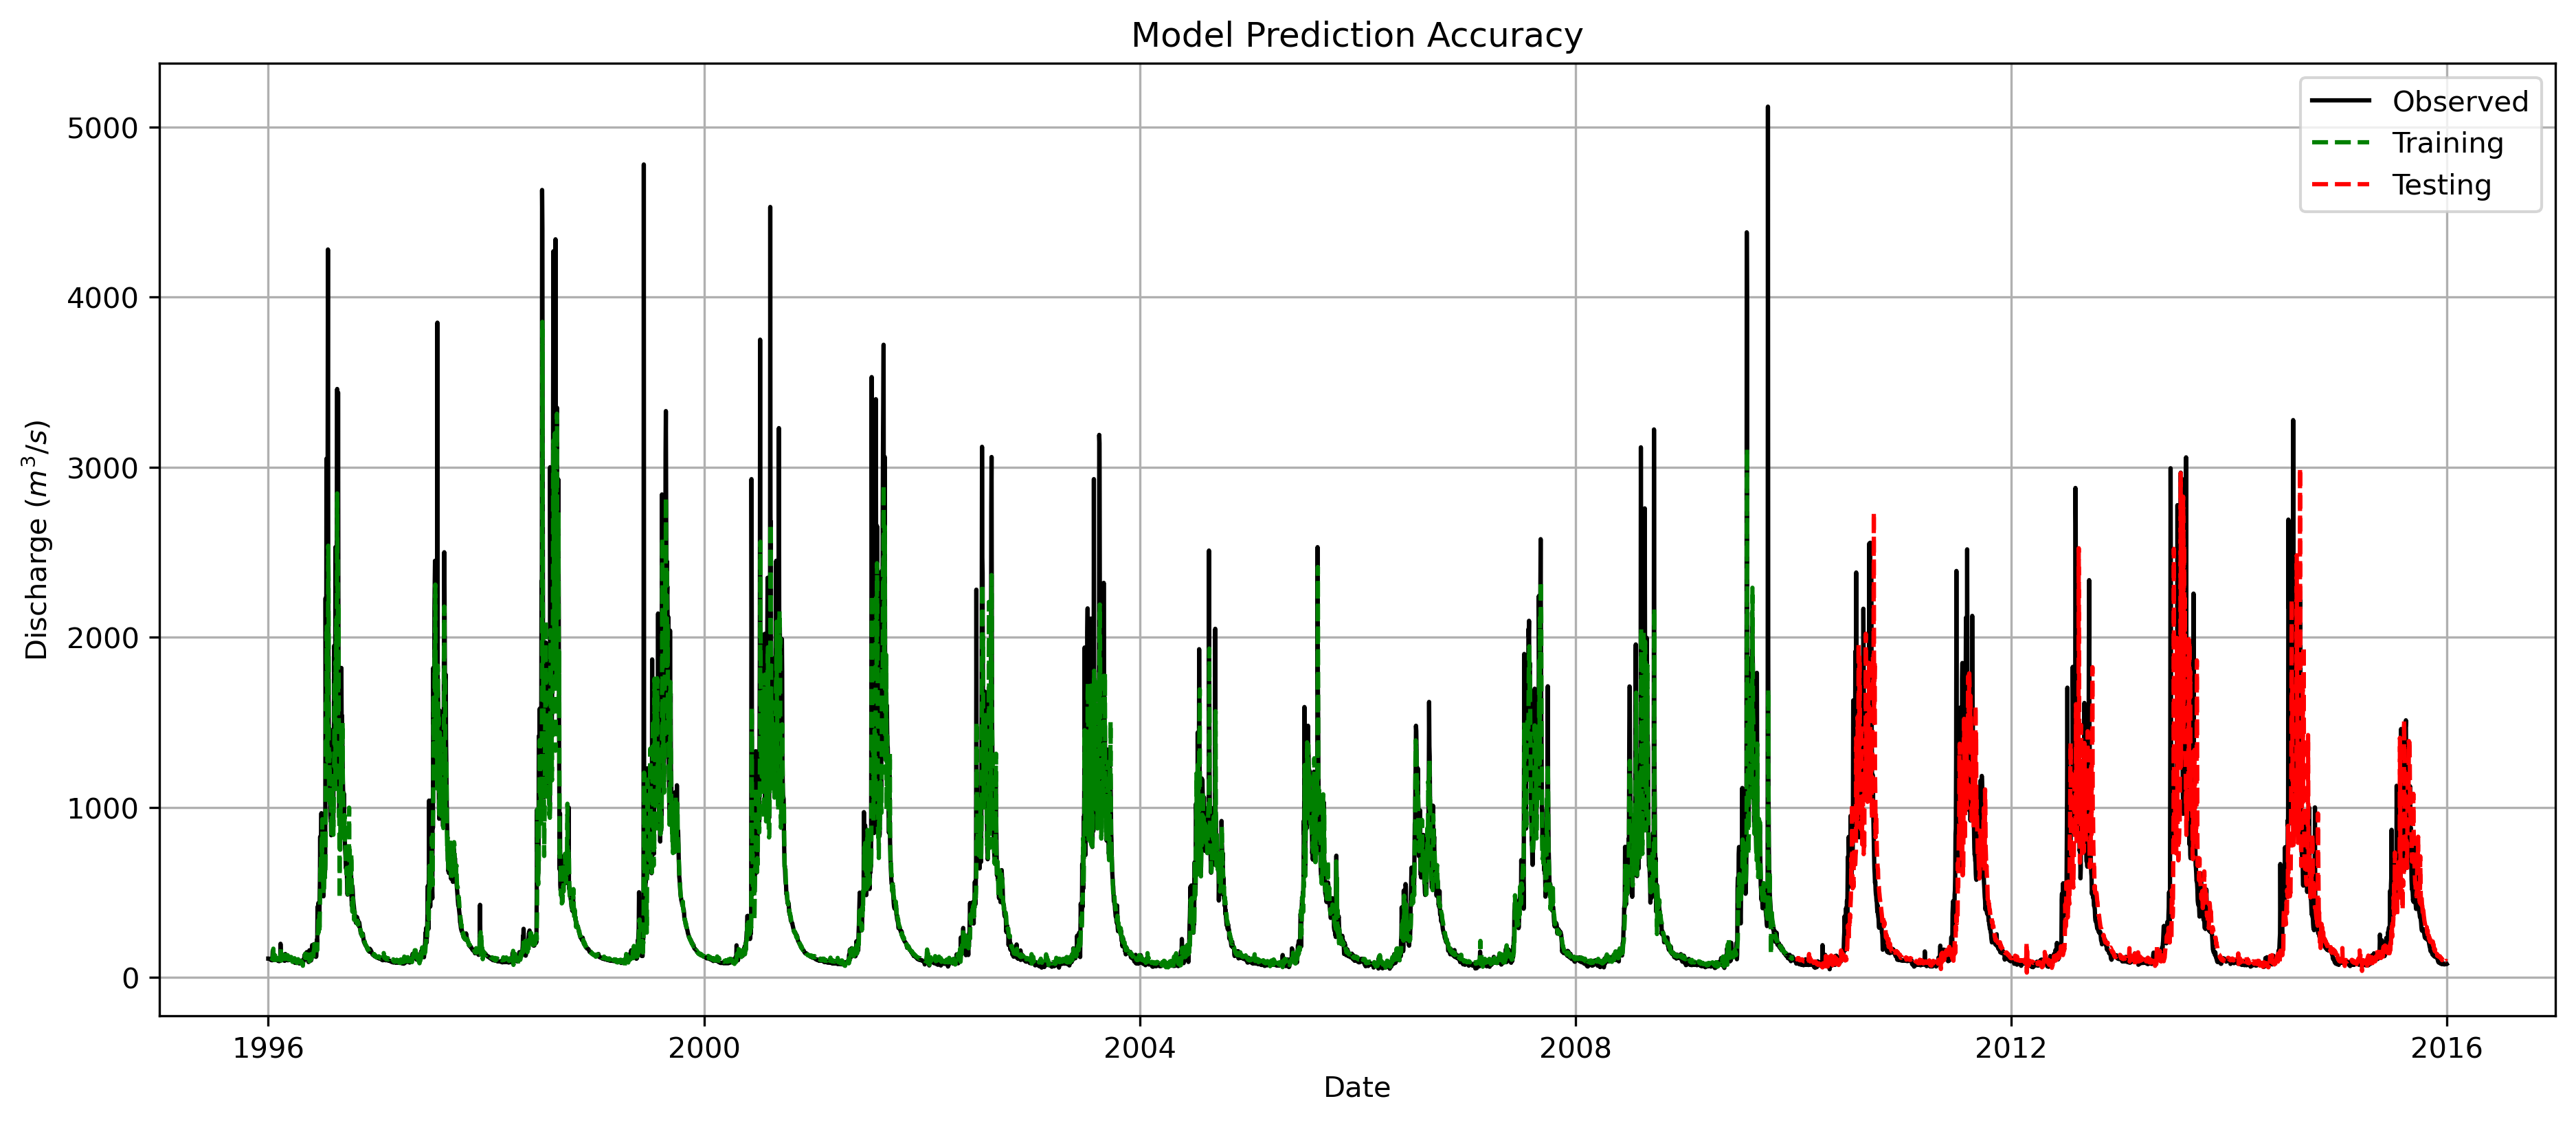

In [241]:
# Plot baseline and predictions
plt.figure(figsize=(15, 6), dpi=300)
plt.plot(data.index, scaler.inverse_transform(data_scaled)[:, 0], label='Observed', color = "black")  # Use the date as the x-axis
plt.plot(data.index[time_step:len(train_predict) + time_step], train_predict_plot[time_step:len(train_predict) + time_step], color = "green", linestyle = "--", label='Training')
plt.plot(data.index[start_idx:end_idx], test_predict_plot[start_idx:end_idx], label='Testing', color = "red", linestyle = "--")
plt.title('Model Prediction Accuracy')
plt.xlabel('Date')
plt.ylabel(r'Discharge $(m^3/s)$')
plt.legend()
plt.grid(True)
plt.show()

### Plot
The plot above illustrates the model's accuracy in predicting streamflow throughout the study period. Overall, the model effectively captures the seasonal and periodic nature of streamflow in both the training and testing phases. Baseflow predictions align closely with observed values, while peak discharges are generally consistent, although some years show higher peaks. Notably, from 1996 to 2000 and in 2009, peak flows ranged from 4000 to 5000 m³/s.

For the Kaligandaki Basin, which lies in the rain-shadow region of the Himalayas, the rainfall distribution varies significantly between the windward and leeward sides. The stations near the outlet, which are located on the leeward side, may record higher rainfall because they are closer to the monsoon winds. However, the northern parts of the basin, situated on the windward side, might experience lower or even negligible rainfall, as the moisture from the monsoon winds is already depleted by the time it reaches these areas. The spatial variation in rainfall across the basin contributes to a weak correlation between rainfall and discharge. In particular, when high rainfall is recorded at stations near the outlet, while the northern parts of the basin receive little to no rainfall, the model tends to underpredict peak discharges.

A survey report published by the World Bank (2015) states that the number of glacial lakes in the basin decreased from 96 to 26, and their area reduced from 3.29 km² to 1.88 km² between 2001 and 2009. This 42.86% reduction in the glacial lake area suggests that the streamflow was influenced not only by rainfall but also by Glacial Lake Outburst Floods (GLOFs). 

---

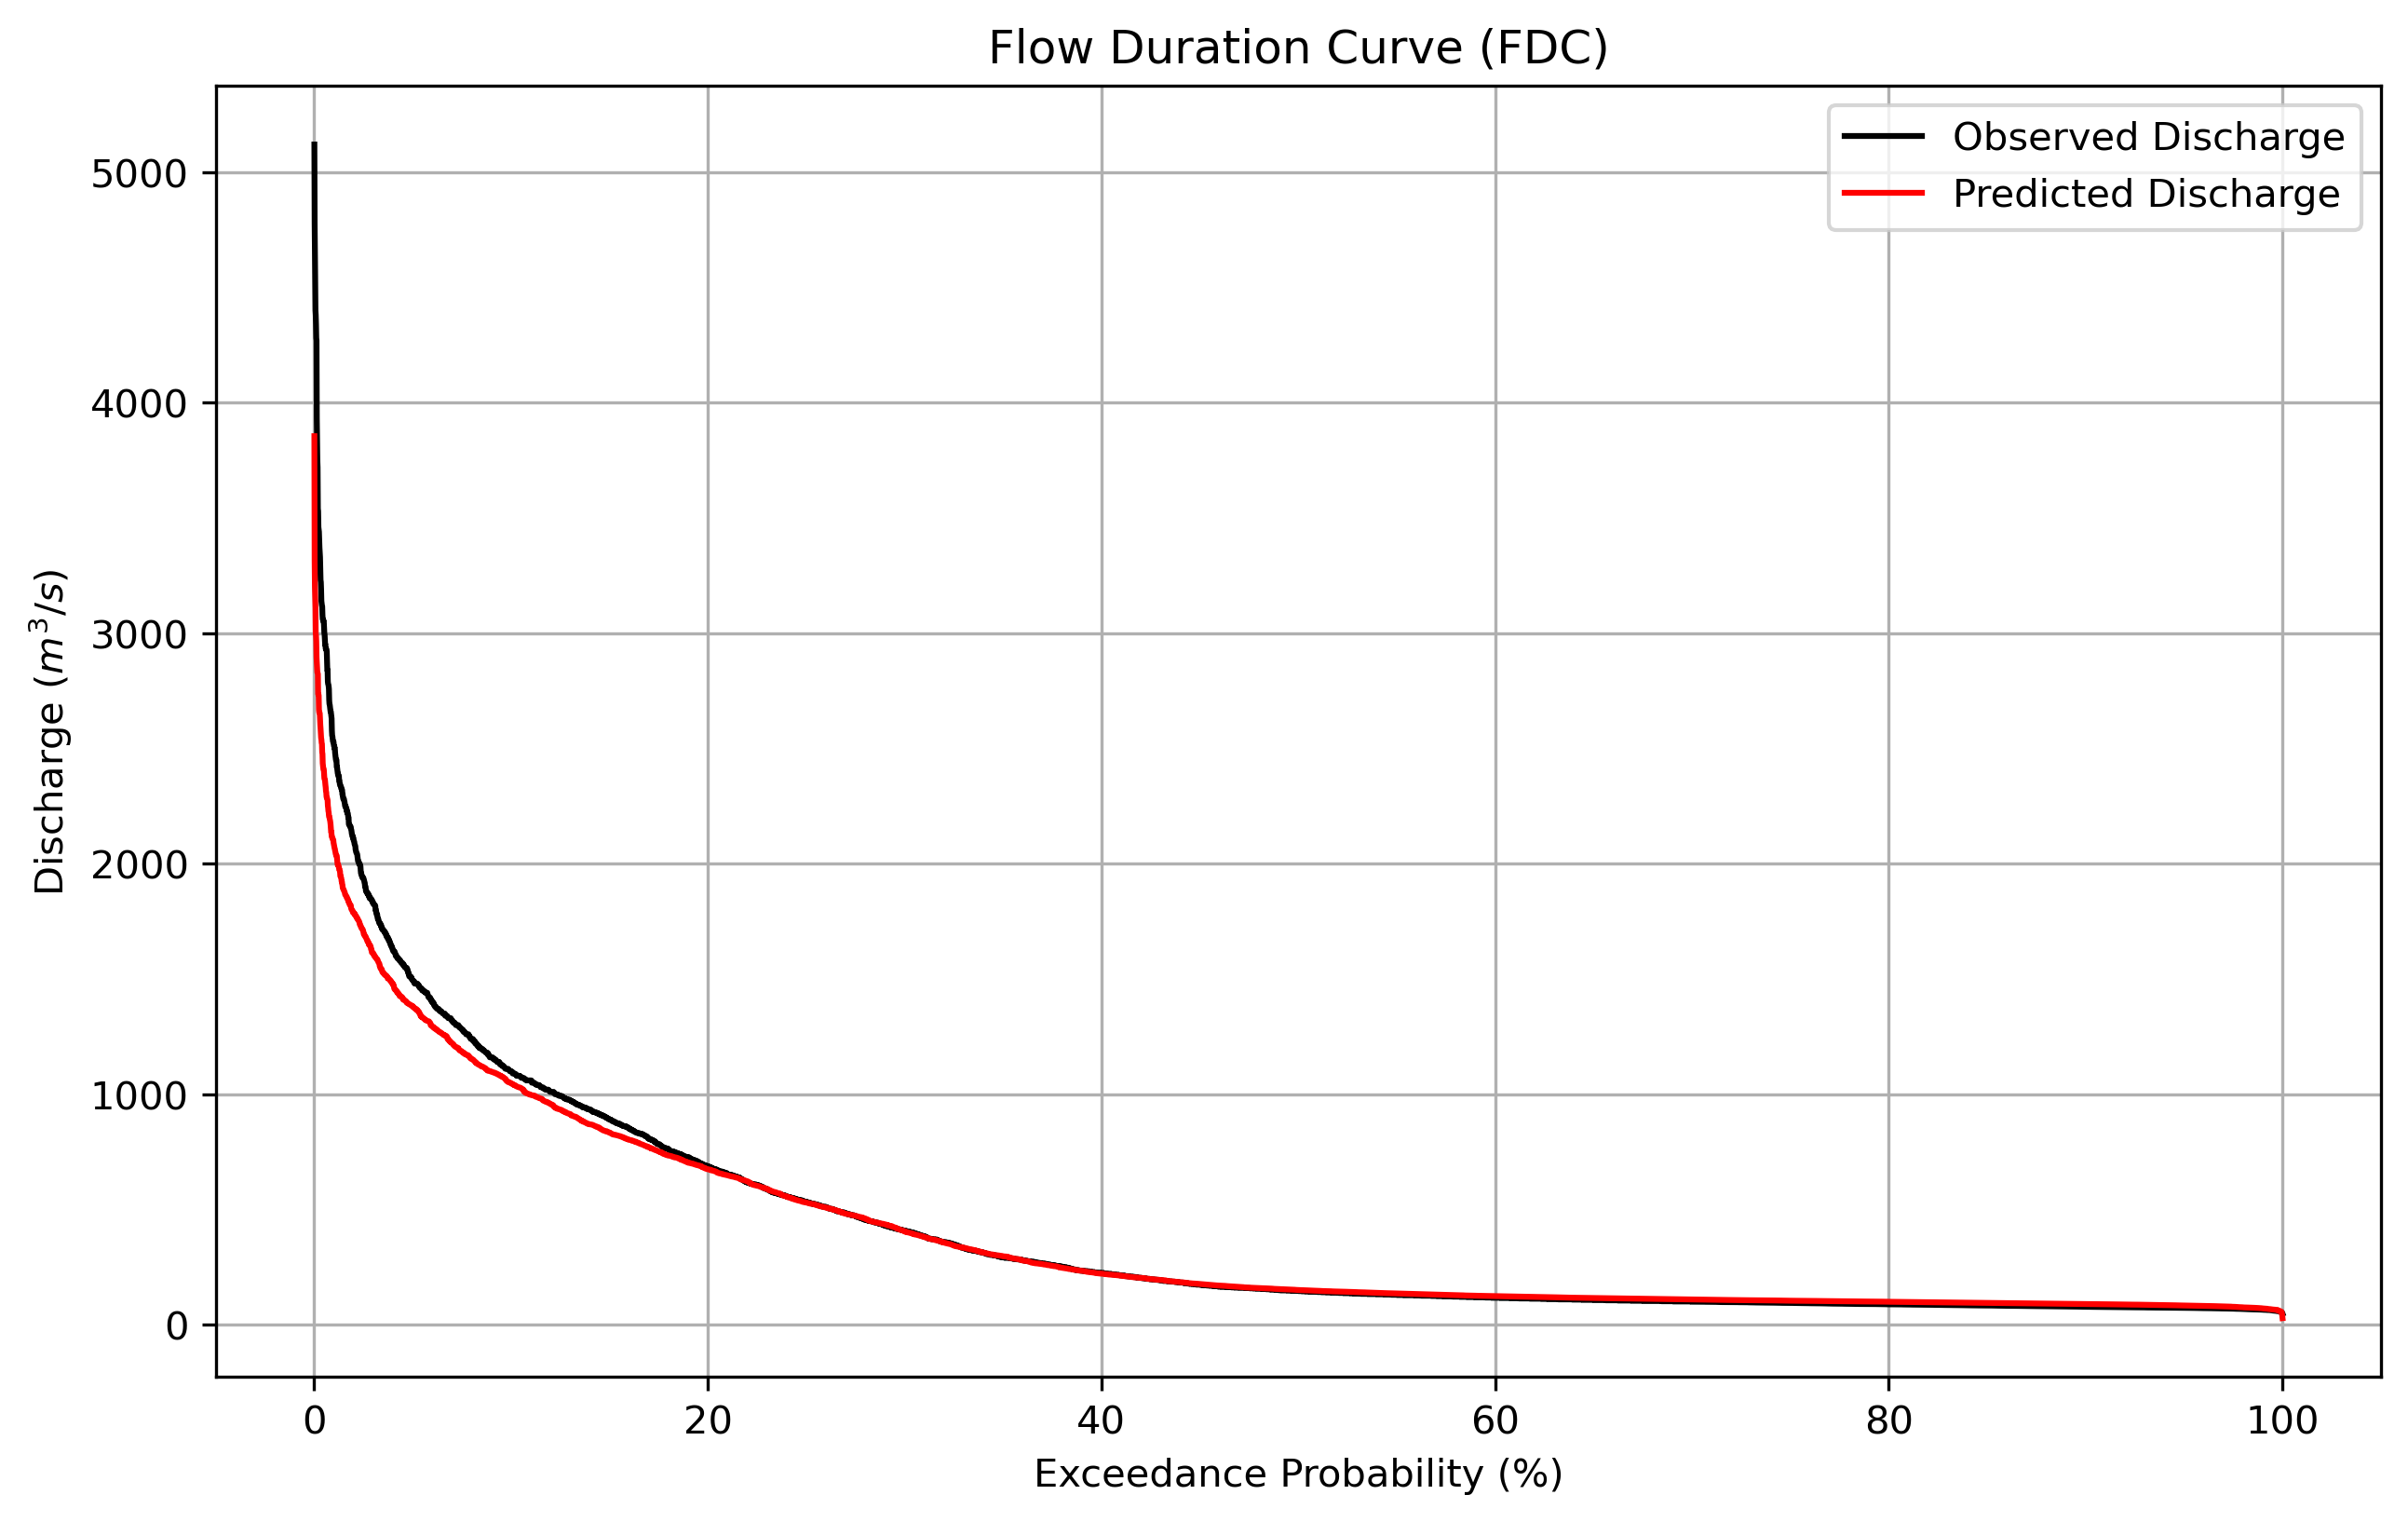

In [243]:
# Observed discharge data
observed_discharge = data['discharge'].values

# Combine observed and predicted discharges for FDC plotting
observed_sorted = np.sort(observed_discharge)[::-1]
predicted_sorted = np.sort(np.concatenate((train_predict, test_predict)))[::-1]

# Calculate exceedance probability
n = len(observed_sorted)
exceedance_probability_observed = np.arange(1, n + 1) / n * 100

n_pred = len(predicted_sorted)
exceedance_probability_predicted = np.arange(1, n_pred + 1) / n_pred * 100

# Plot the Flow Duration Curve
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(exceedance_probability_observed, observed_sorted, label='Observed Discharge', color="black")
plt.plot(exceedance_probability_predicted, predicted_sorted, label='Predicted Discharge', color="red")
plt.xlabel('Exceedance Probability (%)')
plt.ylabel(r'Discharge $(m^3/s)$')
plt.title('Flow Duration Curve (FDC)')
plt.legend()
plt.grid(True)
plt.show()


### Flow Duration Curve (FDC)

A **Flow Duration Curve (FDC)** is a tool used in hydrology to describe the relationship between the magnitude and frequency of streamflow over a specific period. It shows how often certain flow rates are equaled or exceeded, which is useful for understanding river flow variability and planning water resources.

#### Key Features
1. **Discharge Magnitude**: The y-axis represents flow values (discharge), often on a logarithmic scale to handle wide ranges.
2. **Exceedance Probability**: The x-axis shows the percentage of time that each discharge value is equaled or exceeded.
3. **Curve Sections**:
   - **High Flow**: Left side, showing rare but high flow events.
   - **Median Flow**: Middle, representing typical flow conditions.
   - **Low Flow**: Right side, indicating drought or low-flow conditions.
---
The predicted discharge line <span style="color:red">**(Red Line)**</span>is slightly lower than the observed discharge line **(Black Line)** for high-flow values. This indicatees that the observed data includes some higher peak flows that the model may have predcited. This statement supports our output in the plot of ***Observed VS Predicted*** where we see the peaks predicted by the model is somewhat below the observed peak values. For Q20 and lower streamflow values, the predicted and recorded lines align very closely. This implies the model predicts the average flow conditions well. 

The model generally performs well across most flow conditions, capturing both median and low flows accurately. However, it appears to slightly underpredict extreme high flows, as observed by the small gap on the left side of the plot. 

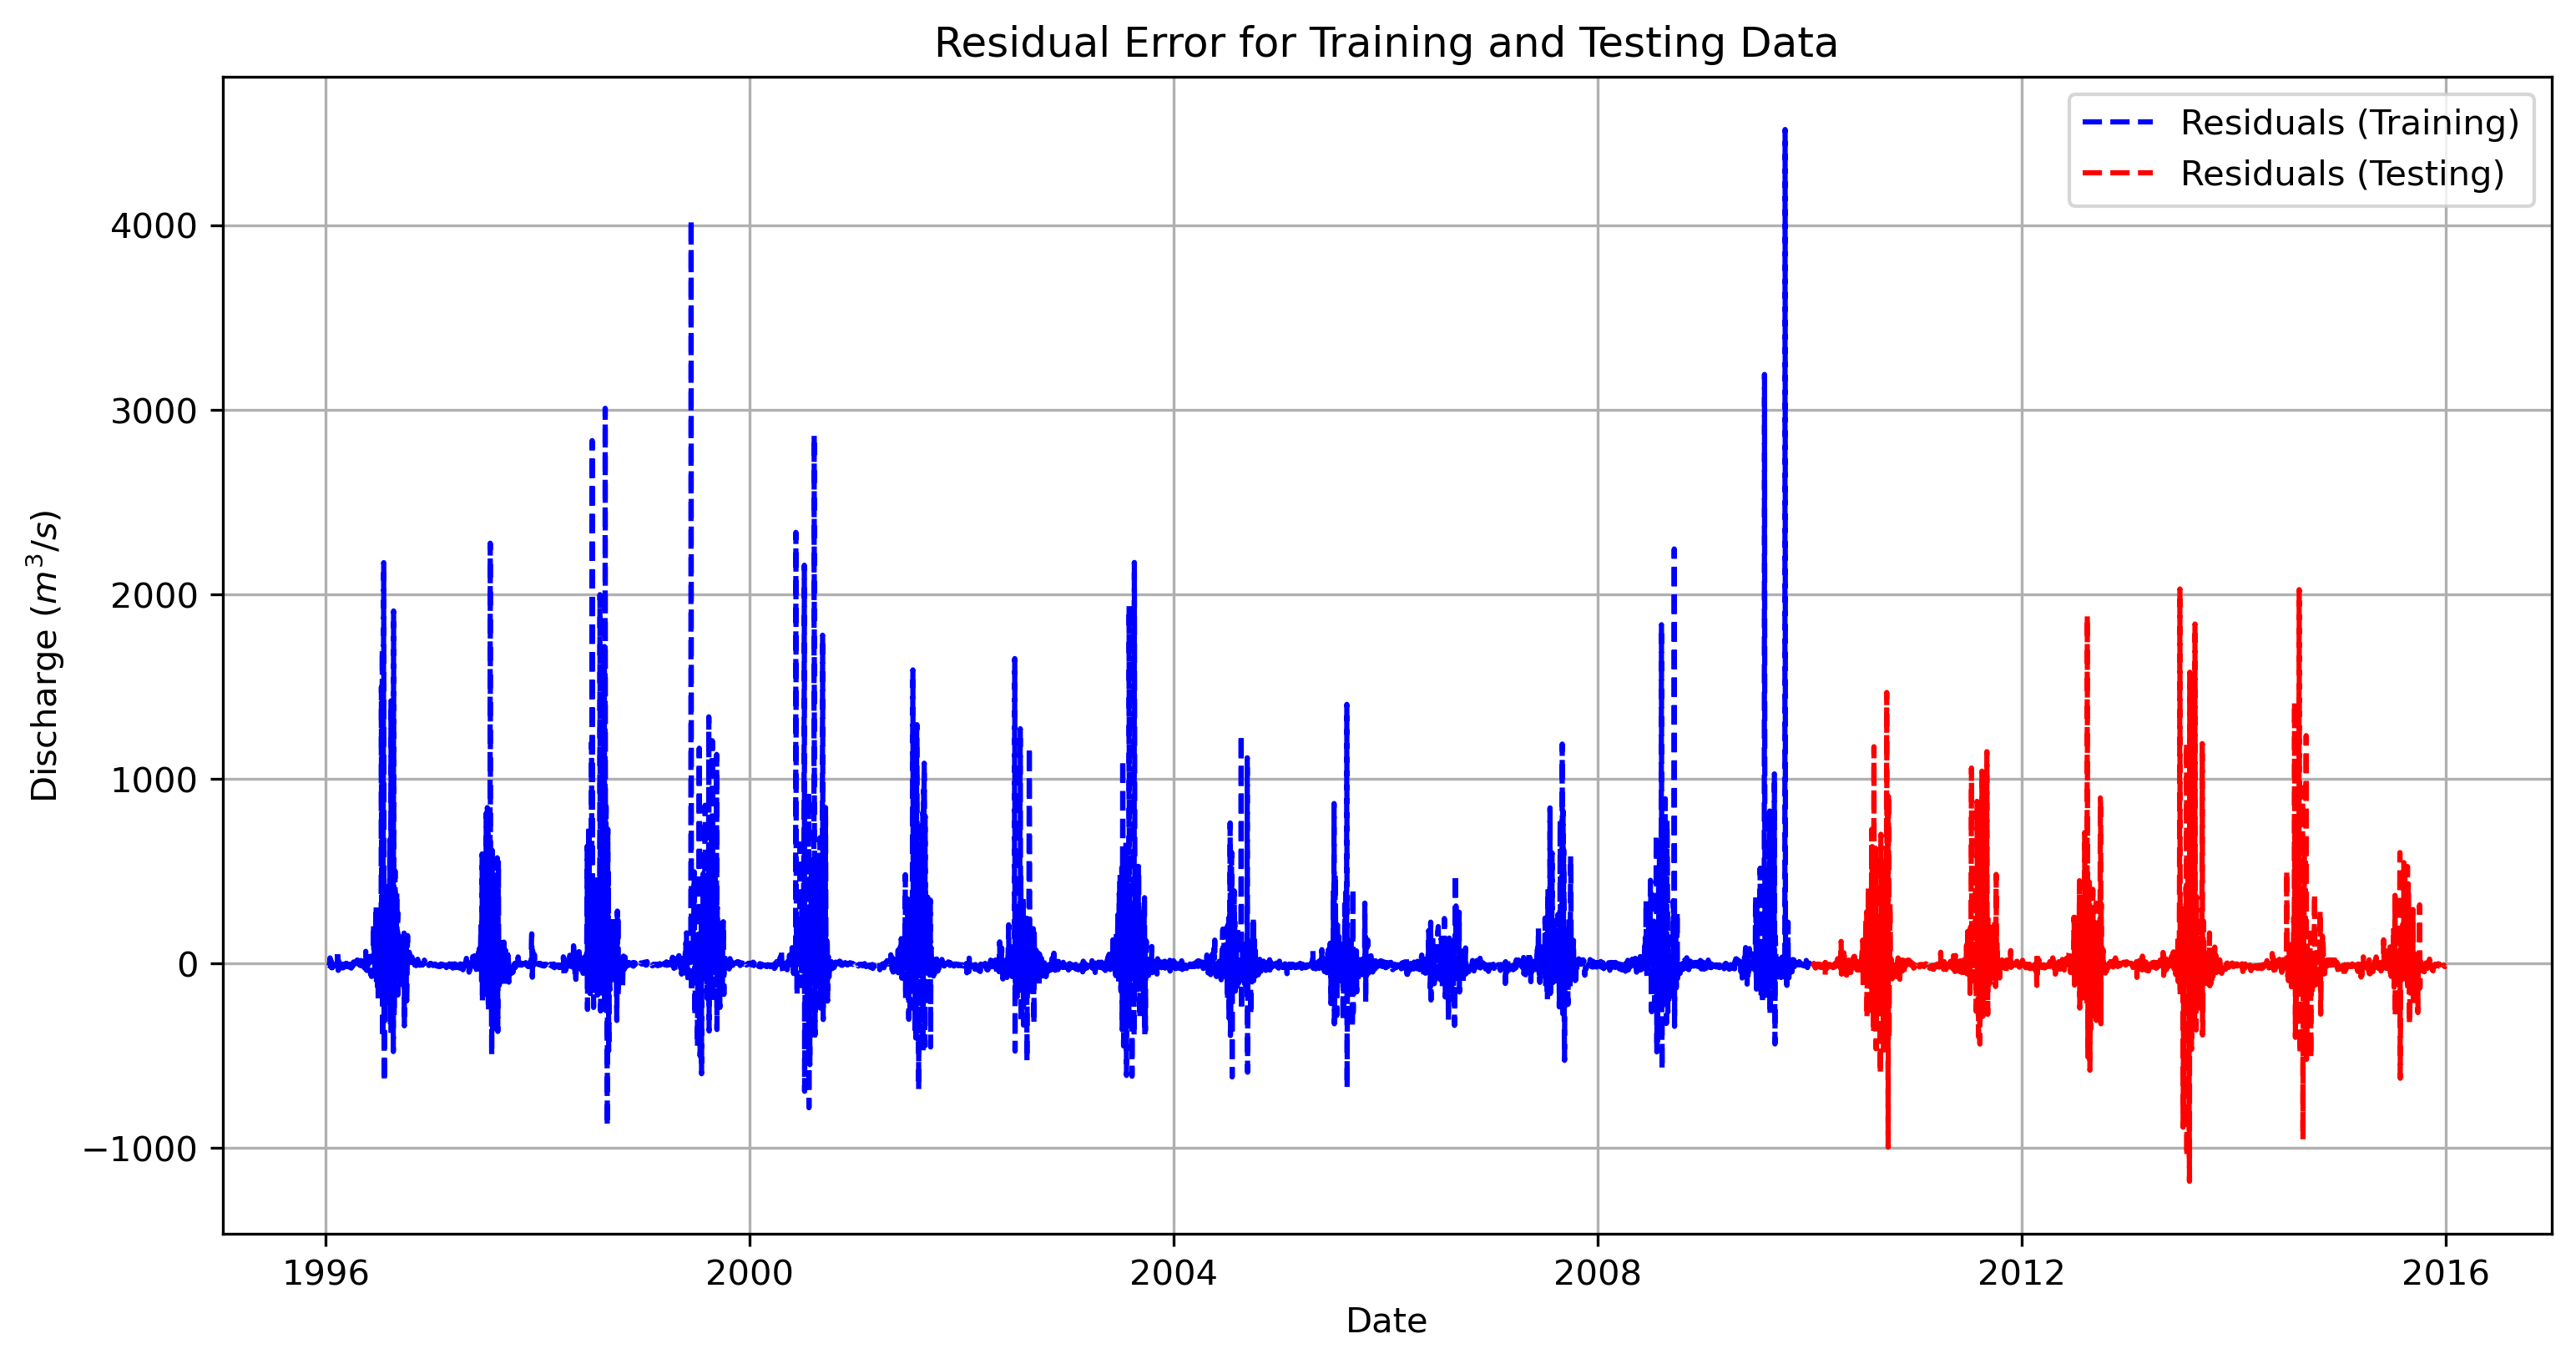

In [245]:
# Calculate residuals for training data
residuals_train = y_train - train_predict

# Calculate residuals for testing data
residuals_test = y_test - test_predict

# Plot residuals for both training and testing data
plt.figure(figsize=(12, 6), dpi=300)

# Residuals for training data
plt.plot(data.index[time_step:time_step + len(residuals_train)], residuals_train, label='Residuals (Training)', color="blue", linestyle="--")

# Residuals for testing data
plt.plot(data.index[start_idx:end_idx], residuals_test[:end_idx - start_idx], label='Residuals (Testing)', color="red", linestyle="--")

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel(r'Discharge $(m^3/s)$')
plt.title('Residual Error for Training and Testing Data')
plt.legend()
plt.grid(True)
plt.show()


### Residual Error

**Residual error** represents the difference between the observed and predicted values in a dataset. It helps assess the accuracy of a model in representing the actual data.
   - Residual error is calculated as:$$     
     \text{Residual} = \text{Observed Value} - \text{Predicted Value}
          $$
   - It shows how much the model's predictions deviate from the actual data points.

**Types of Residuals**:
   - **Positive Residual** Observed > Predicted: The model underpredicts the actual value.
   - **Negative Residual** Observed < Predicted: The model overpredicts the actual value.
   - **Zero Residual** Observed = Predicted: The model prediction is exactly correct.

Residual Plots are often used to analyze the pattern of residuals; ideally, residuals should be randomly scattered, indicating a good model fit.

The residual error plot for training (<span style="color:blue">**in blue**</span>) and testing (<span style="color:red">**in red**</span>) shows residuals for both data centering around zero indicating that the model does not have biasness towards over or under predicting. Some peaks are seen in the plot but note that these are for the high flow events which is acceptable, so the model performs adequately in both low and high flow conditions. Overall, this plot suggests a well trained model with minimal bias and consistent residual patterns over both training and testing datasets indicating a good model.


## Conclusion
This work effectively demonstrates the use of an LSTM model for daily streamflow simulation in the Kaligandaki Basin, emphasizing the model's ability to capture complex, non-linear interactions within the hydrological data. The model obtained Nash-Sutcliffe Efficiency (NSE) scores of 0.8479 during training and 0.8530 during testing by utilizing historical data on temperature, discharge, and rainfall. This indicates that the model is capable of effective hydrological forecasting in the region and that its performance is commendable. While analyzing the FDC, the LSTM model demonstrated the capacity to accurately predict average flow conditions and baseflow in both the training and testing datasets. However, the model demonstrated a minor underprediction for extreme high-flow occurrences, which may be attributed to the difficulties in accurately simulating such peaks as a result of the unique basin topography and the substantial diversity in rainfall distribution. The basin's location in a rain-shadow area results in significant regional variability in precipitation, with stations near the outflow experiencing higher levels of precipitation than those in glaciated regions upstream. The model's robustness was demonstrated in numerous contexts, indicating its significant generalization ability, despite the fact that the features complicate precise streamflow prediction. The residual error analysis demonstrated that the model does not exhibit any significant bias toward over- or under-prediction, as the residuals for both the training and testing datasets are closely centered around zero. This equilibrium suggests that the model is capable of accurately representing typical flow patterns, despite the minor deviations that may occur during high-flow conditions. In addition, the model preserved computational efficiency while effectively capturing long-term relationships by normalizing the data and employing a sliding window of 10 time steps.

Incorporating additional climatic variables into the LSTM model, such as snow cover, glacial discharge, soil moisture, and humidity, might enhance its predictive accuracy for streamflow in elevated regions. This would enhance our understanding of the elements influencing overall streamflow. Adjusting the hyperparameters can enhance the model's ability to identify trends. It is believed that hybrid models, particularly those including both LSTM and convolutional neural networks for feature extraction, will enhance predictive accuracy. Ultimately, the present LSTM model performed exceptionally well. However, these modifications might significantly enhance its reliability, particularly in forecasting severe occurrences. The model's effectiveness in predicting daily streamflow in the complex Kaligandaki area illustrates its performance. To fully realize its potential, further study is required to enhance hybrid models, supplemental data inputs, and training procedures. This study establishes a robust basis for forthcoming hydrological modeling endeavors, highlighting the capability of LSTM to enhance water resource management, flood forecasting, and climate resilience in intricate mountainous basins.

## References
1. Zanfei, A., Brentan, B. M., Menapace, A., & Righetti, M. (2022). A short-term water demand forecasting model using multivariate long short-term memory with meteorological data. Journal of Hydrology, 604, 127191.
2. Calzone, O. (2019, July 14). An intuitive explanation of LSTM. Medium. https://medium.com/@ottaviocalzone/an-intuitive-explanation-of-lstm-a035eb6ab42c
3.Yfilios Solution. (2023, May). Hydrology: Thiessen polygon method. Retrieved from http://www.yfilios-solution.com/2023/05/hydrology-thiessen-polygon-method.html?m=1
4. Bajracharya, A. R., Bajracharya, S. R., Shrestha, A. B., & Maharjan, S. B. (2018). Climate change impact assessment on the hydrological regime of the Kaligandaki Basin, Nepal. Science of the Total Environment, 625, 837-848.
5. Nearing, G. S., Kratzert, F., Sampson, A. K., Pelissier, C. S., Klotz, D., Frame, J. M., Prieto, C., & Gupta, H. V. (2021). What role does hydrological science play in the age of machine learning? Water Resources Research, 57(11), e2021WR030082
6.  Khand, K., & Senay, G. B. (2021). Evaluation of streamflow predictions from LSTM models in water- and energy-limited regions in the United States. Journal of Hydrology, 594, 125847.
7. Moriasi, D. N., Arnold, J. G., Van Liew, M. W., Bingner, R. L., Harmel, R. D., & Veith, T. L. (2007). Model evaluation guidelines for systematic quantification of accuracy in watershed simulations. Transactions of the ASABE, 50(3), 885-900.
8. Nash, J. E., and J. V. Sutcliffe. 1970. River flow forecasting through 
conceptual models: Part 1. A discussion of principles. J. Hydrolog 
10(3): 282-29
9. World Bank. (2015). Glacial lakes and glacial lake outburst floods in Nepal. Retrieved from https://documents1.worldbank.org/curated/ar/150061467986261271/pdf/98829-WP-Box393178B-PUBLIC-Glacial-lakes-and-glacial-late-outburst-floods-in-Nepal.pdf0.